# Importing Packages

In [1]:
# %pip install 'tensorflow[and-cuda]'
# %pip install transformers
# %pip install tf-keras
# %pip install tensorflow-hub

In [121]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow_hub as hub
import cv2
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import seaborn as sns
import numpy as np
from PIL import Image
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
# model = TFAutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

In [3]:
!nvidia-smi

Fri Jan 31 09:28:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             13W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16433637931407934060
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4781692761267996654
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 212838249950880692
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data Ingestion

In [7]:
# !unzip ./final_dataset_2.zip -d ./final_dataset_2
# !unzip ./val_images.zip -d ./val_images

In [12]:
df = pd.read_csv('/kaggle/input/final-memes-dataset-cleaned/final_dataset.csv')
df.head()

,image_path,label,meme_text,file_extension,language_code,sentence_length,average_word_length,hashtags_count,emails_count,numbers_count,usernames_count,websites,pos_tags,named_entities,new_image_path,meme_text_masked
0,./dataset/violence against women meme offensiv...,1,When mom takes away my fidget spinner.,jpg,Language.ENGLISH,7,4.571429,0,0,0,0,[],"['SCONJ', 'NOUN', 'VERB', 'ADV', 'PRON', 'NOUN...",[],final_dataset/Image_15_0d42f67a-74dd-4415-b286...,When mom takes away my fidget spinner.
1,./dataset/violence against women meme offensiv...,1,Morning wood? You mean my wife's alarm clock.,jpg,Language.ENGLISH,8,4.750000,0,0,0,0,[],"['NOUN', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'PRO...",[],final_dataset/Image_14_255b3022-61df-4e4e-93d0...,Morning wood? You mean my wife's alarm clock.
2,./dataset/violence against women meme offensiv...,1,When captain man calls you to the man cave at ...,jpg,Language.ENGLISH,23,3.956522,0,0,0,0,[],"['SCONJ', 'NOUN', 'NOUN', 'VERB', 'PRON', 'ADP...",['TIME'],final_dataset/Image_16_fa940fca-ef00-4425-851e...,When captain man calls you to the man cave at ...
3,./dataset/violence against women meme offensiv...,1,KILL ALL JEWISHS.,jpg,Language.ENGLISH,3,5.000000,0,0,0,0,[],"['VERB', 'DET', 'PROPN', 'PUNCT']",['ORG'],final_dataset/Image_17_bb0e97ae-e051-4482-a394...,KILL ALL JEWISHS.
4,./dataset/violence against women meme offensiv...,1,The violence has escalated.,png,Language.ENGLISH,4,6.000000,0,0,0,0,[],"['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']",[],final_dataset/Image_13_b5413513-2d35-4269-bf4f...,The violence has escalated.


3it [00:00, 56.86it/s]


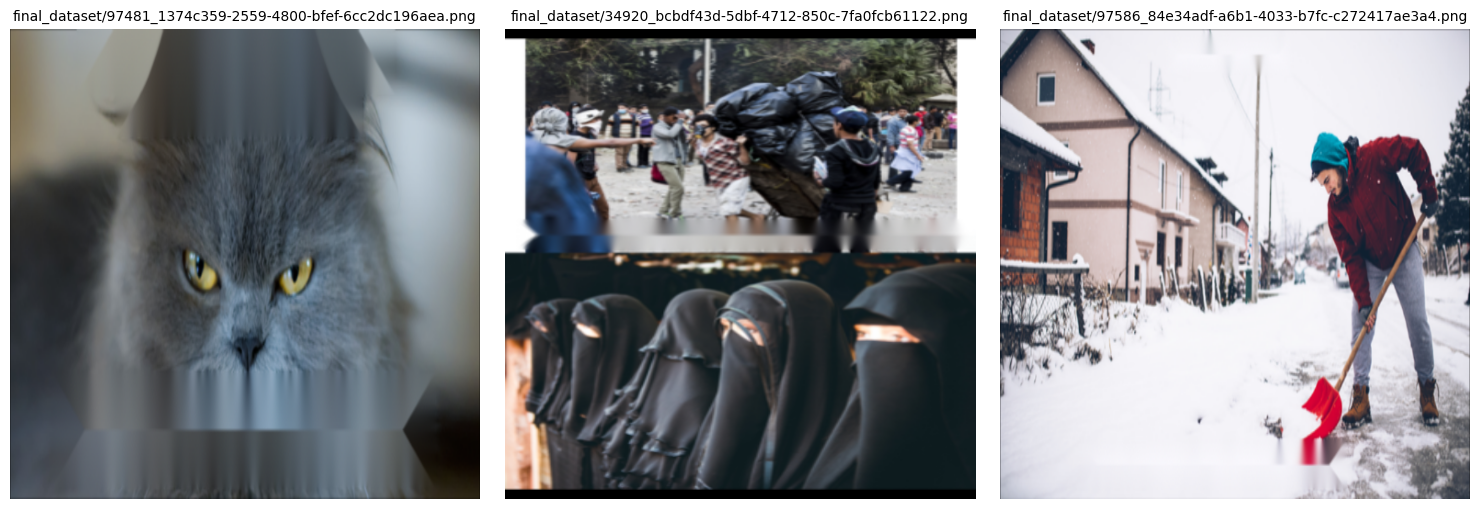

In [13]:
def display_random_images(df, image_column):
    sampled_rows = df.sample(n=3)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, (_, row) in tqdm(zip(axes, sampled_rows.iterrows())):
        try:
            image_path = row[image_column].replace("final_dataset/", "/kaggle/input/final-memes-dataset-cleaned/final_dataset 2/final_dataset/")
            image_path = f"{image_path}"
            
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')  # Turn off axis
            
            ax.set_title(row[image_column], fontsize=10)
        except Exception as e:
            ax.set_title("Error loading image", fontsize=10)
            ax.axis('off')
            print(f"Error loading image: {e}")
    
    plt.tight_layout()
    plt.show()

display_random_images(df, "new_image_path")

In [14]:
df['new_image_path'] = df['new_image_path'].str.replace("final_dataset/", "/kaggle/input/final-memes-dataset-cleaned/final_dataset 2/final_dataset/")
df['new_image_path'].head()

0    /kaggle/input/final-memes-dataset-cleaned/fina...
1    /kaggle/input/final-memes-dataset-cleaned/fina...
2    /kaggle/input/final-memes-dataset-cleaned/fina...
3    /kaggle/input/final-memes-dataset-cleaned/fina...
4    /kaggle/input/final-memes-dataset-cleaned/fina...
Name: new_image_path, dtype: object

# Generating Feature Embeddings

In [15]:
train_df = df[["new_image_path", "meme_text_masked", "label"]]
train_df.head()

,new_image_path,meme_text_masked,label
0,/kaggle/input/final-memes-dataset-cleaned/fina...,When mom takes away my fidget spinner.,1
1,/kaggle/input/final-memes-dataset-cleaned/fina...,Morning wood? You mean my wife's alarm clock.,1
2,/kaggle/input/final-memes-dataset-cleaned/fina...,When captain man calls you to the man cave at ...,1
3,/kaggle/input/final-memes-dataset-cleaned/fina...,KILL ALL JEWISHS.,1
4,/kaggle/input/final-memes-dataset-cleaned/fina...,The violence has escalated.,1


In [97]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print("Training set:")
print("Training shape:", train_df.shape)
display(train_df.head())

print("Validation set:")
print("Testing shape:", val_df.shape)
display(val_df.head())

Training set:
Training shape: (6320, 3)


,new_image_path,meme_text_masked,label
9303,/kaggle/input/final-memes-dataset-cleaned/fina...,perfect girls don't exi-,1
2799,/kaggle/input/final-memes-dataset-cleaned/fina...,"men are such pigs, i hate them all why can't i...",0
9221,/kaggle/input/final-memes-dataset-cleaned/fina...,why do black people smell bad? so blind people...,1
436,/kaggle/input/final-memes-dataset-cleaned/fina...,What if I told you pasteurizing milk kills the...,1
34,/kaggle/input/final-memes-dataset-cleaned/fina...,If you wanna be my lover you gotta get.,1


Validation set:
Testing shape: (703, 3)


,new_image_path,meme_text_masked,label
2209,/kaggle/input/final-memes-dataset-cleaned/fina...,"dont you care about my future? stop the ""refug...",1
3773,/kaggle/input/final-memes-dataset-cleaned/fina...,when you pick her up for a date and she got ha...,0
7798,/kaggle/input/final-memes-dataset-cleaned/fina...,we're glad you're home,0
6255,/kaggle/input/final-memes-dataset-cleaned/fina...,trump supporters be like fucking mexicans,1
1192,/kaggle/input/final-memes-dataset-cleaned/fina...,Corporate needs you to find the differences be...,1


## Finetuning Bert for Text Classification

In [54]:
# bert finetuning
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

train_texts, train_labels = train_df["meme_text_masked"].tolist(), train_df["label"].tolist()
val_texts, val_labels = val_df["meme_text_masked"].tolist(), val_df["label"].tolist()

In [55]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

In [59]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(train_labels)))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/30
488/488 [==============================] - 112s 197ms/step - loss: 0.6976 - accuracy: 0.5296 - val_loss: 0.6914 - val_accuracy: 0.5320
Epoch 2/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6902 - accuracy: 0.5428 - val_loss: 0.6911 - val_accuracy: 0.5320
Epoch 3/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6903 - accuracy: 0.5446 - val_loss: 0.6912 - val_accuracy: 0.5320
Epoch 4/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6900 - accuracy: 0.5415 - val_loss: 0.6914 - val_accuracy: 0.5320
Epoch 5/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6900 - accuracy: 0.5420 - val_loss: 0.6913 - val_accuracy: 0.5320
Epoch 6/30
488/488 [==============================] - 94s 193ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6915 - val_accuracy: 0.5320
Epoch 7/30
488/488 [==============================] - 94s 192ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6915 - val_a

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict()

## Finetuning ViT for Image Classification

## Bert and ViT (early fusion)

## Bert and ViT (Late fusion)

## CLIP based approach (early fusion)

In [17]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = TFCLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [98]:
df['meme_text_masked'] = df['meme_text_masked'].fillna("").astype(str)
# df['new_image_path'] = df['new_image_path'].apply(lambda x: f"./{x}" if not x.startswith("./") else x)
df['meme_text_masked'] = df['meme_text_masked'].replace("", "No text provided")

In [99]:
from tensorflow.keras.layers import Dense, Lambda

def get_clip_embeddings_with_adapters(image_paths, texts, batch_size=32, embedding_dim=1024, alpha=0.5):
    image_embeds = []
    text_embeds = []

    # Iterate through batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing Batches"):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_texts = texts[i:i + batch_size]

        try:
            # Load images
            images = [Image.open(p).convert("RGB") for p in batch_image_paths]
        except Exception as e:
            print(f"Error loading images in batch {i // batch_size + 1}. Example image paths: {batch_image_paths}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error loading images

        try:
            # Get CLIP model embeddings
            inputs = clip_processor(text=batch_texts, images=images, return_tensors="tf", padding=True)
            outputs = clip_model(**inputs)

            image_embeds.append(outputs.image_embeds.numpy())
            text_embeds.append(outputs.text_embeds.numpy())
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}. Example texts: {batch_texts}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error processing text and images

    # Concatenate all batches
    if image_embeds and text_embeds:
        image_embeds = np.concatenate(image_embeds, axis=0)
        text_embeds = np.concatenate(text_embeds, axis=0)

        # Define linear projection layers
        image_proj_layer = Dense(embedding_dim, name="image_projection")
        text_proj_layer = Dense(embedding_dim, name="text_projection")

        # Apply projection
        F_proj_I = image_proj_layer(image_embeds)
        F_proj_T = text_proj_layer(text_embeds)

        # Define feature adapters
        image_adapter = Dense(embedding_dim, activation='relu', name="image_adapter")
        text_adapter = Dense(embedding_dim, activation='relu', name="text_adapter")

        # Apply adapters
        A_I = image_adapter(F_proj_I)
        A_T = text_adapter(F_proj_T)

        # Compute final representations with residual connections
        F_I = alpha * A_I + (1 - alpha) * F_proj_I
        F_T = alpha * A_T + (1 - alpha) * F_proj_T

        return F_I.numpy(), F_T.numpy()
    else:
        print("No valid embeddings generated.")
        return np.array([]), np.array([])

# Call the updated function
image_embeds, text_embeds = get_clip_embeddings_with_adapters(
    df['new_image_path'].tolist(), 
    df['meme_text_masked'].tolist(),
    embedding_dim=1024, 
    alpha=0.5
)

Processing Batches: 100%|██████████| 305/305 [06:00<00:00,  1.18s/it]


In [100]:
labels = df['label'].values
num_classes = len(np.unique(labels))
num_classes

2

In [101]:
# modality fusion

fused_embeds = image_embeds * text_embeds 
fused_embeds

array([[-2.3957216e-06, -9.9531643e-04, -5.3626229e-04, ...,
         1.5983936e-04, -6.7054125e-04, -2.0234462e-05],
       [-7.0487251e-05, -7.1502611e-04, -4.0300493e-04, ...,
         8.4723288e-05,  2.0161156e-04,  1.4512304e-03],
       [-1.3071734e-04,  9.0184418e-05,  5.8500918e-05, ...,
         5.5443251e-04, -4.5480632e-04,  8.1873652e-05],
       ...,
       [ 8.7885235e-07, -1.0198282e-04,  8.9929366e-05, ...,
        -4.0195420e-05, -1.3031186e-04, -3.3897315e-05],
       [ 3.4010940e-05, -7.0554734e-04,  2.5403553e-05, ...,
        -3.6198835e-05,  1.7437225e-04,  1.5115466e-04],
       [ 2.2208889e-05, -5.2534102e-04, -3.3660620e-04, ...,
        -3.4186713e-05,  5.7124806e-04,  1.0398645e-04]], dtype=float32)

In [102]:
fused_embeds.shape

(9755, 1024)

In [103]:
# Create a stratified split
fused_embeds_train, fused_embeds_val, labels_train, labels_val = train_test_split(
    fused_embeds, labels, 
    test_size=0.2,        # 20% for validation
    stratify=labels,      # Ensures equal label distribution
    random_state=42       # For reproducibility
)

In [104]:
def classification_model(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    # First hidden layer
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Second hidden layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = classification_model(input_dim, num_classes)
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classification_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,289 (548.00 KB)

 Trainable params: 139,905 (546.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [105]:
optimizer = Adam(learning_rate=0.001)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with early stopping
history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6652 - loss: 0.6002 - val_accuracy: 0.5423 - val_loss: 0.6873
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7501 - loss: 0.5048 - val_accuracy: 0.7109 - val_loss: 0.6580
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7728 - loss: 0.4693 - val_accuracy: 0.7304 - val_loss: 0.5336
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4227 - val_accuracy: 0.7360 - val_loss: 0.5260
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.3962 - val_accuracy: 0.7453 - val_loss: 0.5795
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3646 - val_accuracy: 0.7263 - val_loss: 0.5726
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3229 - val_accuracy: 0.7417 - val_loss: 0.5814
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.2788 - val_accu

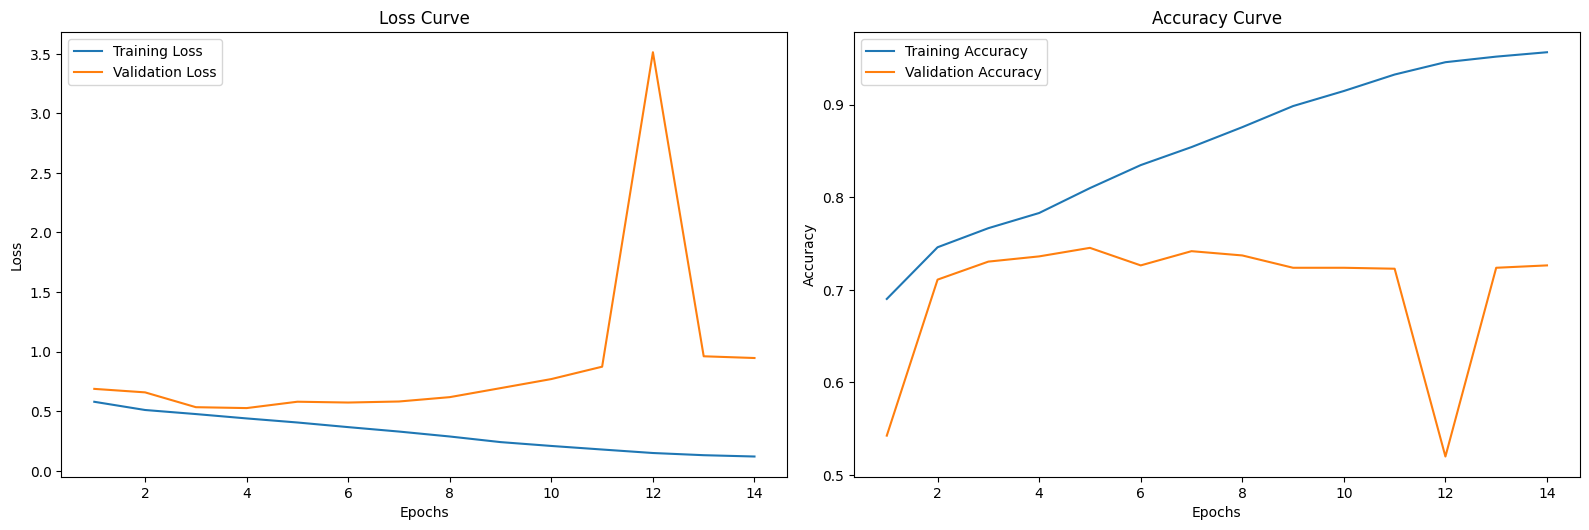

In [107]:
def plot_training_curves(history):
    # Extract metrics from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [108]:
def build_classification_model_with_residual(input_dim, num_classes=2):
    inputs = layers.Input(shape=(input_dim,))
    
    # First block with residual connection
    x = layers.Dense(1024, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(inputs)  # L2 regularization
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual1 = layers.Dense(1024, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual1 = layers.BatchNormalization()(residual1)  # Batch Normalization
    x = layers.Add()([x, residual1])
    
    # Second block with residual connection
    x = layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual2 = layers.Dense(512, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual2 = layers.BatchNormalization()(residual2)  # Batch Normalization
    x = layers.Add()([x, residual2])
    
    # Third block with residual connection
    x = layers.Dense(256, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Increased dropout for regularization
    residual3 = layers.Dense(256, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01))(x)
    residual3 = layers.BatchNormalization()(residual3)  # Batch Normalization
    x = layers.Add()([x, residual3])
    
    # Fourth block without residuals for bottleneck
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)  # Batch Normalization
    x = layers.Dropout(0.6)(x)  # Dropout for regularization

    # Output layer: classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = fused_embeds.shape[1]
num_classes = 2

classification_model = build_classification_model_with_residual(input_dim, num_classes=num_classes)
classification_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1024)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 1024)           │      1,049,600 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 1024)           │          4,096 │ dense_38[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1024)           │      1,049,600 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 1024)           │          4,096 │ dense_39[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 1024)           │              0 │ dropout_16[0][0],      │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 512)            │        524,800 │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 512)            │          2,048 │ dense_40[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 512)            │        262,656 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 512)            │          2,048 │ dense_41[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 512)            │              0 │ dropout_17[0][0],      │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 256)            │        131,328 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 256)            │          1,024 │ dense_42[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout) 

 Total params: 3,131,649 (11.95 MB)

 Trainable params: 3,124,225 (11.92 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [109]:
optimizer = AdamW(learning_rate=1e-4)
classification_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

history = classification_model.fit(
    fused_embeds_train, labels_train,
    validation_data=(fused_embeds_val, labels_val),  # Provide validation data
    epochs=100,
    batch_size=32,  # Optimal value 32
    shuffle=True,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.4983 - loss: 40.3101 - val_accuracy: 0.5423 - val_loss: 37.1695
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5481 - loss: 36.5723 - val_accuracy: 0.5423 - val_loss: 33.7525
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5513 - loss: 33.1922 - val_accuracy: 0.6253 - val_loss: 30.7057
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5651 - loss: 30.2456 - val_accuracy: 0.6530 - val_loss: 28.0489
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5966 - loss: 27.6409 - val_accuracy: 0.6591 - val_loss: 25.6903
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6125 - loss: 25.3062 - val_accuracy: 0.6699 - val_loss: 23.5572
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6298 - loss: 23.2014 - val_accuracy: 0.6791 - val_loss: 21.6148
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 2

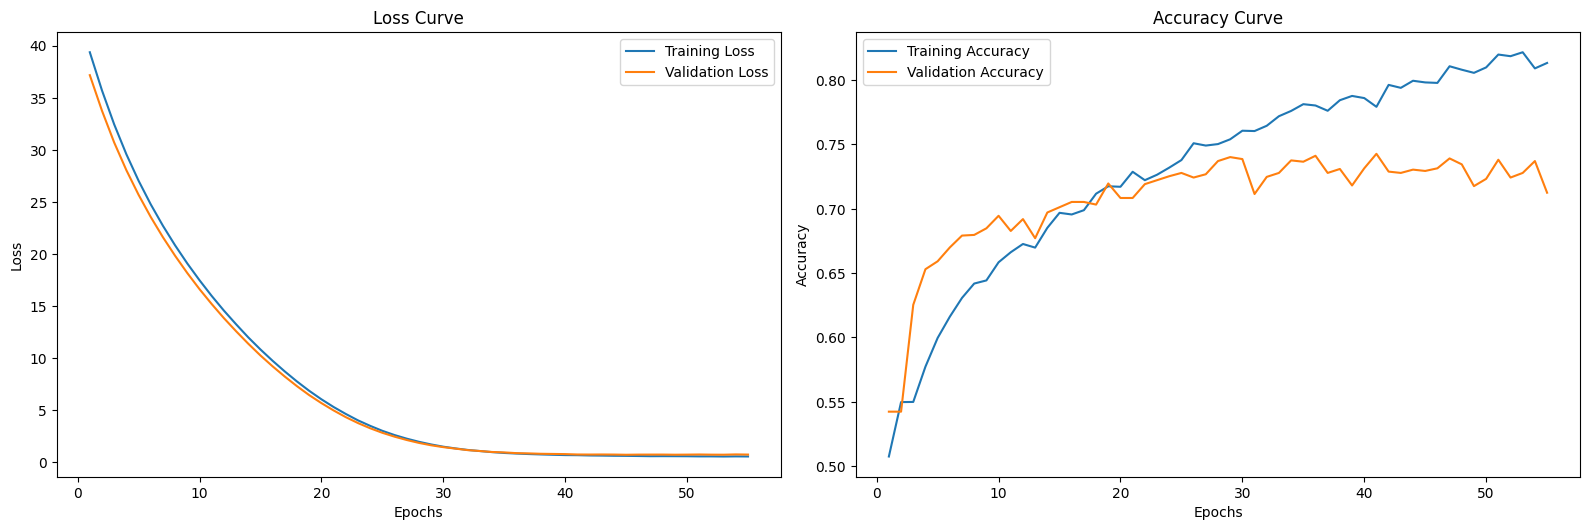

In [111]:
plot_training_curves_and_metrics(history)

## Model Performance Evaluation

In [112]:
test_df = pd.read_csv('/kaggle/input/testing-memes/val_dataset.csv', index_col=0)
test_df.head()

,id,img,label,text,processed_text,processed_img_path
0,8291,./data/img/08291.png,1,white people is this a shooting range,white people is this a shooting range,./val_images/08291.png
1,46971,./data/img/46971.png,1,bravery at its finest,bravery at its finest,./val_images/46971.png
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...,./val_images/03745.png
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...,./val_images/83745.png
4,80243,./data/img/80243.png,1,mississippi wind chime,mississippi wind chime,./val_images/80243.png


In [113]:
prefix = '/kaggle/input/testing-memes/val_images/'
test_df['processed_img_path'] = test_df['processed_img_path'].str.replace("./", prefix)
test_df.head()

,id,img,label,text,processed_text,processed_img_path
0,8291,./data/img/08291.png,1,white people is this a shooting range,white people is this a shooting range,/kaggle/input/testing-memes/val_images/val_ima...
1,46971,./data/img/46971.png,1,bravery at its finest,bravery at its finest,/kaggle/input/testing-memes/val_images/val_ima...
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...,/kaggle/input/testing-memes/val_images/val_ima...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...,/kaggle/input/testing-memes/val_images/val_ima...
4,80243,./data/img/80243.png,1,mississippi wind chime,mississippi wind chime,/kaggle/input/testing-memes/val_images/val_ima...


In [114]:
labels_test = test_df['label']

In [115]:
image_embeds, text_embeds = get_clip_embeddings_with_adapters(
    test_df['processed_img_path'].tolist(),
    test_df['processed_text'].tolist(),  
    embedding_dim=1024, 
    alpha=0.5
)

test_fused_embeds = image_embeds * text_embeds 
test_fused_embeds

Processing Batches: 100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


array([[ 1.3744893e-03,  6.2020088e-04, -3.6561338e-05, ...,
         3.4514203e-05,  6.2860979e-04,  7.6442833e-05],
       [ 6.8774796e-04,  6.7120529e-04,  2.8590659e-05, ...,
        -7.3244344e-05,  1.2014160e-04, -1.5197929e-04],
       [ 9.8274276e-04,  4.2274164e-04, -1.5568239e-05, ...,
        -7.5587205e-04,  7.9517580e-05, -3.7691640e-04],
       ...,
       [ 6.3985464e-04,  6.2266941e-04,  8.2751583e-05, ...,
        -5.2525394e-04,  3.5933073e-04, -1.0169489e-04],
       [ 3.9141954e-04,  1.4133530e-04,  9.6280339e-05, ...,
        -1.8315739e-04,  1.2054079e-04, -1.9630809e-04],
       [ 1.3738003e-03,  8.6643163e-04, -4.0648545e-05, ...,
        -5.2990261e-05,  6.2383636e-04,  8.5331696e-05]], dtype=float32)

In [116]:
y_pred_prob = classification_model.predict(test_fused_embeds)
y_pred = (y_pred_prob > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [117]:
y_pred_prob = classification_model.predict(test_fused_embeds)
y_pred = (y_pred_prob > 0.5).astype(int)

from pprint import pprint
pprint(classification_report(labels_test, y_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.56      0.10      0.16       250\n'
 '           1       0.51      0.92      0.65       250\n'
 '\n'
 '    accuracy                           0.51       500\n'
 '   macro avg       0.53      0.51      0.41       500\n'
 'weighted avg       0.53      0.51      0.41       500\n')


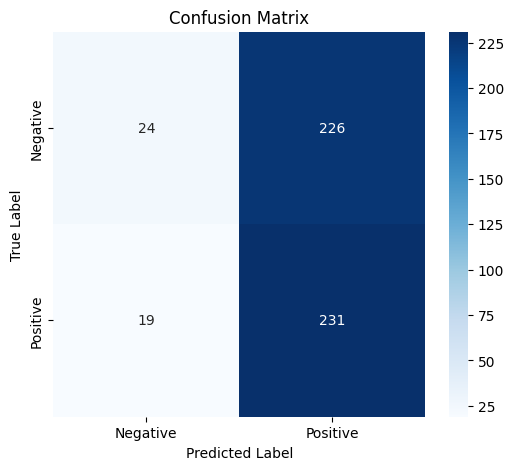

In [119]:
cm = confusion_matrix(labels_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

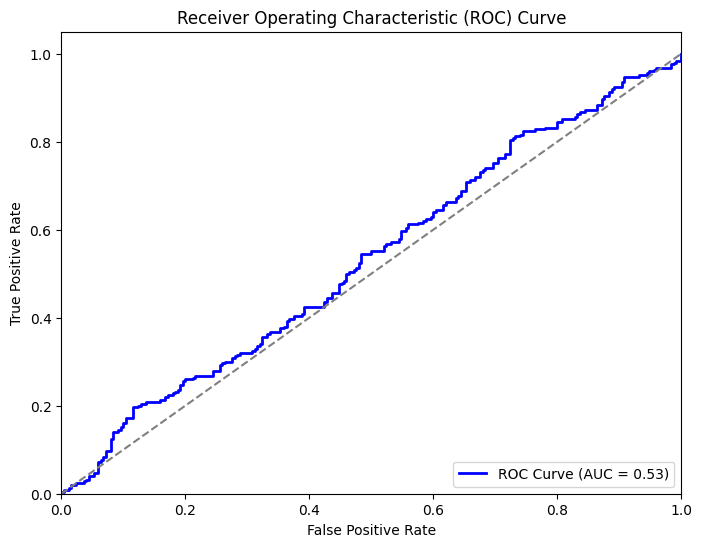

In [118]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(labels_test, y_pred_prob)  # Use probabilities for ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

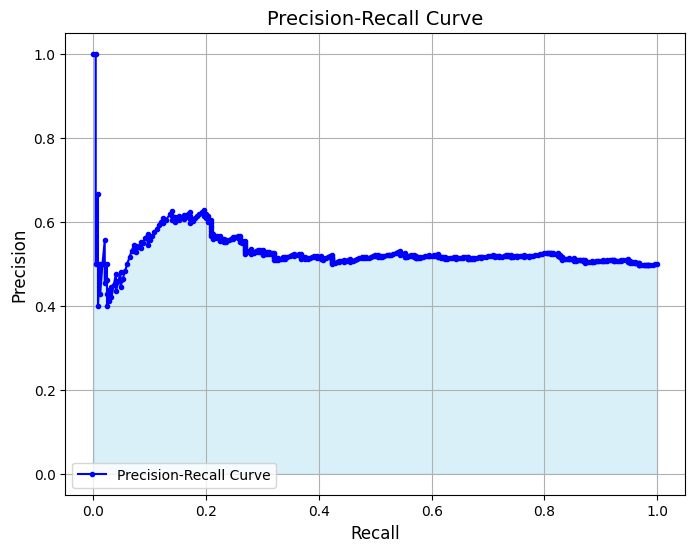

In [127]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds from predicted probabilities
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='b', label='Precision-Recall Curve')
plt.fill_between(recall, precision, color='skyblue', alpha=0.3)
plt.title('Precision-Recall Curve', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


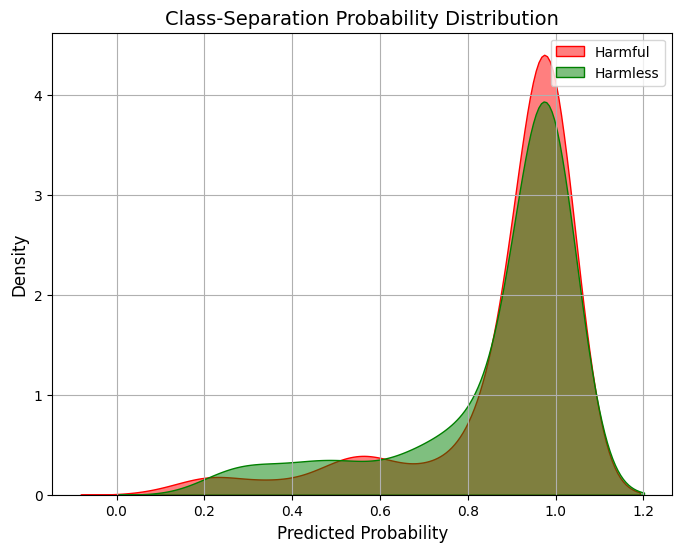

In [141]:
harmful_probs = y_pred_prob[labels_test == 1]  # Harmful memes (label=1)
harmless_probs = y_pred_prob[labels_test == 0]  # Harmless memes (label=0)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(harmful_probs.squeeze(), label='Harmful', fill=True, color='red', alpha=0.5)
sns.kdeplot(harmless_probs.squeeze(), label='Harmless', fill=True, color='green', alpha=0.5)
plt.title('Class-Separation Probability Distribution', fontsize=14)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [133]:
sorted_probs = np.sort(y_pred_prob)[::-1]
sorted_labels = labels_test[np.argsort(y_pred_prob)[::-1]]

# Cumulative gain calculation
cumulative_gains = np.cumsum(sorted_labels) / np.sum(sorted_labels)

# Plotting the Cumulative Gain chart
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 100, len(cumulative_gains)), cumulative_gains * 100, label="Model")
plt.plot([0, 100], [0, 100], linestyle='--', label="Random", color='gray')  # Random guessing line
plt.title('Cumulative Gain Chart', fontsize=14)
plt.xlabel('% of Tested Memes', fontsize=12)
plt.ylabel('% of Harmful Memes Detected', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

ValueError: Cannot index with multidimensional key

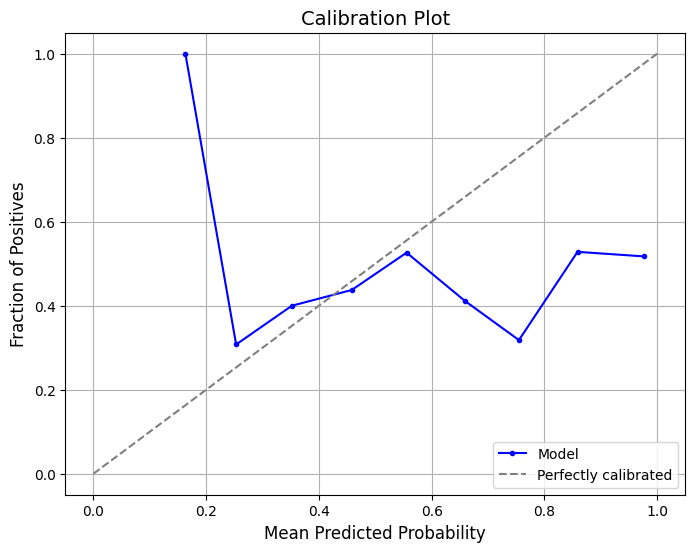

In [134]:
from sklearn.calibration import calibration_curve

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_pred_prob, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='.', color='b', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')  # Ideal line
plt.title('Calibration Plot', fontsize=14)
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Testing against adverserial attacks

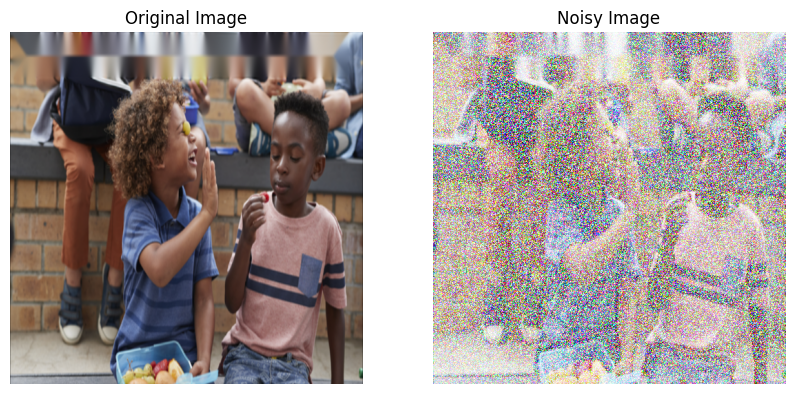

In [122]:
def add_gaussian_noise(image_path, noise_level=10):
    image = cv2.imread(image_path)
    noise = np.random.normal(0, noise_level, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    
    # Convert back to PIL format for compatibility with your pipeline
    return Image.fromarray(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))

# Example: Apply noise to a sample image
sample_image_path = test_df['processed_img_path'].iloc[0]
noisy_image = add_gaussian_noise(sample_image_path)

# Show original and noisy images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open(sample_image_path))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(noisy_image)
ax[1].set_title("Noisy Image")
ax[1].axis("off")

plt.show()

In [125]:
def get_clip_embeddings_with_adapters(image_inputs, texts, batch_size=32, embedding_dim=1024, alpha=0.5):
    image_embeds = []
    text_embeds = []

    for i in tqdm(range(0, len(image_inputs), batch_size), desc="Processing Batches"):
        batch_images = image_inputs[i:i + batch_size]
        batch_texts = texts[i:i + batch_size]

        # Load images only if they are file paths
        try:
            if isinstance(batch_images[0], str):  # If paths are given, load them
                images = [Image.open(p).convert("RGB") for p in batch_images]
            else:  # Otherwise, assume images are already pre-processed
                images = batch_images
        except Exception as e:
            print(f"Error loading images in batch {i // batch_size + 1}. Example images: {batch_images[:2]}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error loading images

        try:
            # Get CLIP model embeddings
            inputs = clip_processor(text=batch_texts, images=images, return_tensors="tf", padding=True)
            outputs = clip_model(**inputs)

            image_embeds.append(outputs.image_embeds.numpy())
            text_embeds.append(outputs.text_embeds.numpy())
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}. Example texts: {batch_texts[:2]}")
            print(f"Error: {e}")
            continue  # Skip this batch if there's an error processing text and images

    # Concatenate all batches
    if image_embeds and text_embeds:
        image_embeds = np.concatenate(image_embeds, axis=0)
        text_embeds = np.concatenate(text_embeds, axis=0)

        # Define linear projection layers
        image_proj_layer = Dense(embedding_dim, name="image_projection")
        text_proj_layer = Dense(embedding_dim, name="text_projection")

        # Apply projection
        F_proj_I = image_proj_layer(image_embeds)
        F_proj_T = text_proj_layer(text_embeds)

        # Define feature adapters
        image_adapter = Dense(embedding_dim, activation='relu', name="image_adapter")
        text_adapter = Dense(embedding_dim, activation='relu', name="text_adapter")

        # Apply adapters
        A_I = image_adapter(F_proj_I)
        A_T = text_adapter(F_proj_T)

        # Compute final representations with residual connections
        F_I = alpha * A_I + (1 - alpha) * F_proj_I
        F_T = alpha * A_T + (1 - alpha) * F_proj_T

        return F_I.numpy(), F_T.numpy()
    else:
        print("No valid embeddings generated.")
        return np.array([]), np.array([])

In [126]:
# Run inference on the original and noisy image
original_pred = classification_model.predict(get_clip_embeddings_with_adapters([sample_image_path], ["sample text"])[0])
print(f"Original Prediction: {original_pred}")

noisy_pred = classification_model.predict(get_clip_embeddings_with_adapters([noisy_image], ["sample text"])[0])
print(f"Noisy Image Prediction: {noisy_pred}")

Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Original Prediction: [[1.]]


Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Noisy Image Prediction: [[1.]]


## Explainability

# Exporting Best Model

In [19]:
# classification_model.save('classification_model.h5') 

converter = tf.lite.TFLiteConverter.from_keras_model(classification_model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxpalmmu/assets


Saved artifact at '/tmp/tmpgxpalmmu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140283672841904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140289157982944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680365856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680358464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680362336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680360400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680373424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283680370256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140283672667312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140285858787952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140284036858800: Tens

W0000 00:00:1737432219.200128    1680 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737432219.200152    1680 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 04:03:39.200979: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.203100: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 04:03:39.203122: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpgxpalmmu
I0000 00:00:1737432219.223305    1680 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-21 04:03:39.228662: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 04:03:39.403179: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpgxpalmmu
2025-01-21 04:03:39.445861: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [20]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='best_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
